In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
ds = pd.read_csv('caras.csv')

# 1. Inspección de los datos
El dataset caras.csv contiene 800 imágenes de 68 × 68 pixeles en escala de grises, junto con sus etiquetas de clase. Para realizar un análisis exploratorio de estos datos, se proponen los siguientes puntos:

## a) Graficar Imagenes
Implementar una función que pueda graficar un número arbitrario de imágenes del dataset. Mostrar un ejemplo de un gráfico con 15 imágenes seleccionadas de manera aleatoria.
Esta función va a ser necesaria a lo largo de todo el trabajo, por lo que se deberá ir adaptando de acuerdo a las necesidades que vayan surgiendo.

In [18]:
def plot_random_img(ds, n_img=15, rand_seed=None):
    """
    Selecciona n_img imágenes aleatorias del dataset y las muestra en una grilla. Por defecto, muestra 15 imágenes.
    """
    sample = ds.sample(n_img, random_state=rand_seed)
    cols = min(n_img, 5)
    rows = int(np.ceil(n_img / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < n_img:
                img = sample.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {sample.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

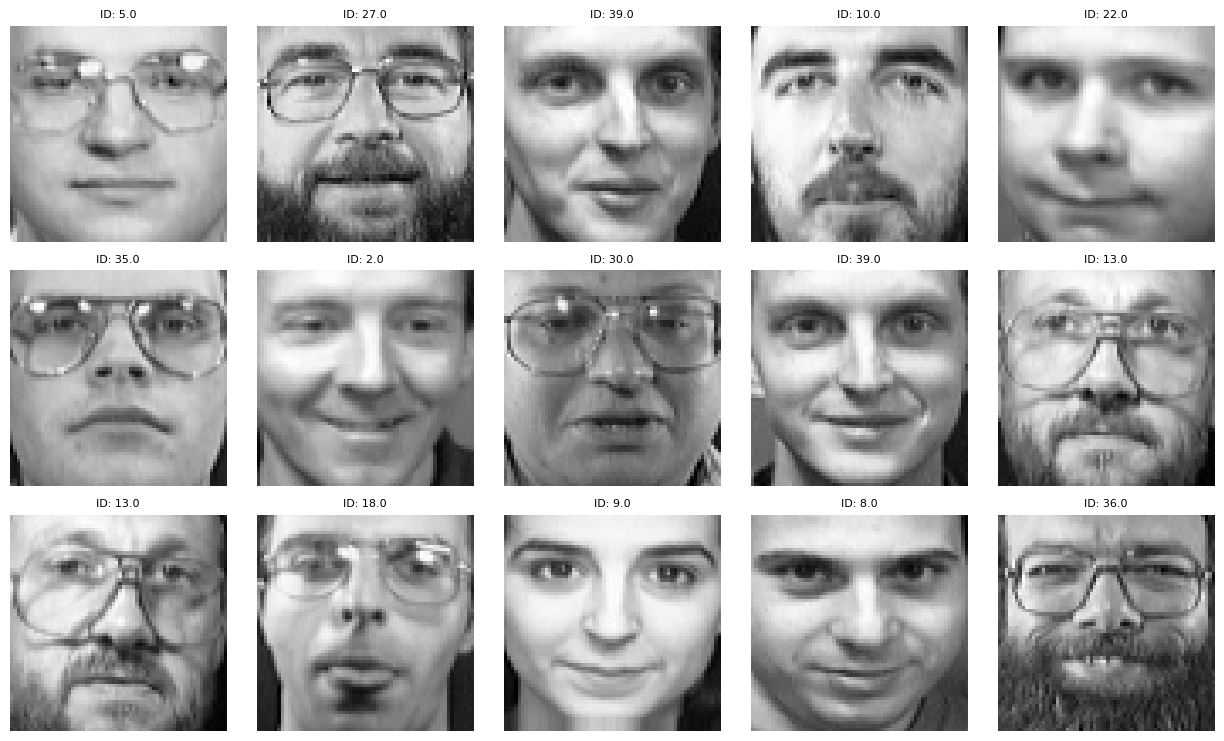

In [19]:
plot_random_img(ds, n_img=15, rand_seed=43)

## b) Analizar distribucion por clase
Realizar un analisis exploratorio enfocado en la distribución de clases en los datos.

In [16]:
def plot_distribution(ds, target_col='person_id'):
  ids = ds[target_col]
  counts = ids.value_counts().sort_index()
  classes = counts.index.to_numpy()
  values  = counts.values
  cmap = plt.get_cmap('tab20', len(classes))
  colors = [cmap(i) for i in range(len(classes))]

  plt.figure(figsize=(10,4))
  plt.bar(classes, values, color=colors, width=0.9)
  plt.xlabel('person_id')
  plt.ylabel('frecuencia')
  plt.xticks(classes)         # asegura ticks en cada clase
  plt.title('Distribución por clase')
  plt.tight_layout()
  plt.show()

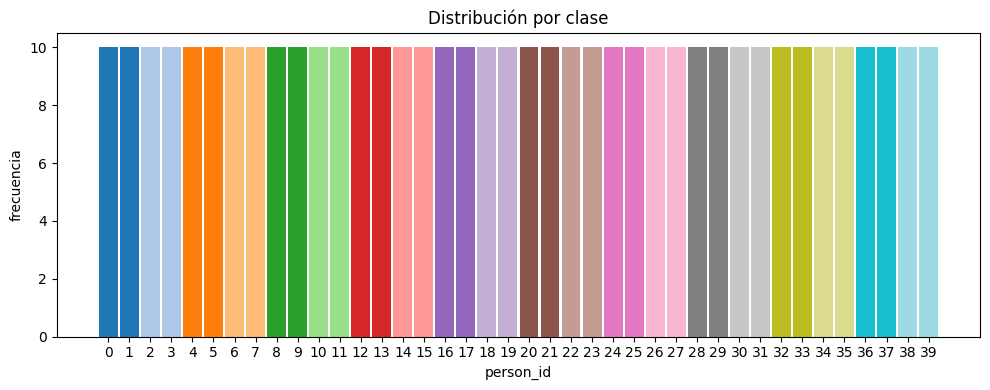

In [17]:
plot_distribution(ds)

 Para tener una mejor noción de la variabilidad de las muestras, graficar muestras agrupadas por clase, para al menos 5 clases.

In [26]:
def plot_by_class(ds, ids, num_img, rand_seed=None):
  """
    Recibe una lista de ids de personas y muestra 5 imágenes correspondientes a cada etiqueta id. Asume un minimo de 5 muestras por clase.
  """
  for id in ids:
    imgs = ds[ds['person_id'] == id].sample(num_img, random_state=rand_seed)
    cols = num_img
    rows = int(np.ceil(5 / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < num_img:
                img = imgs.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {imgs.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

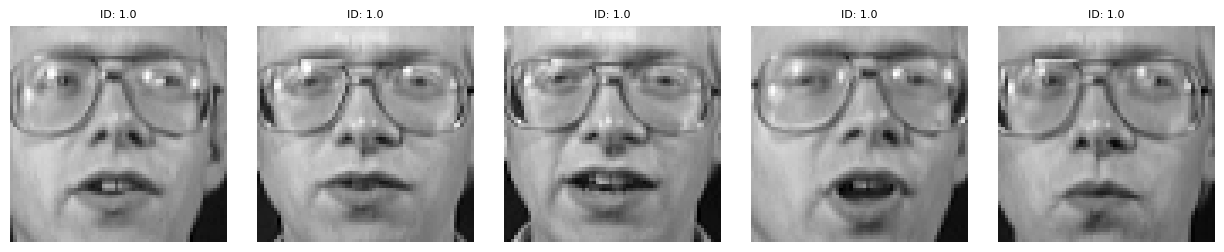

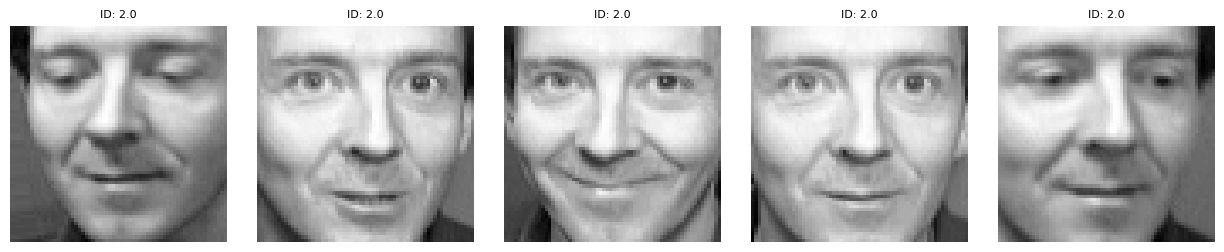

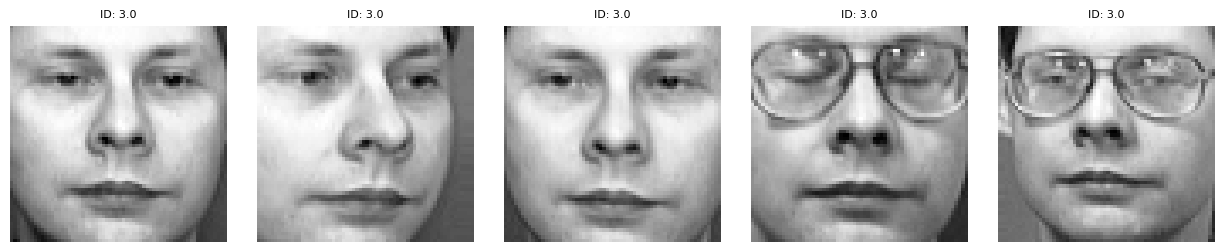

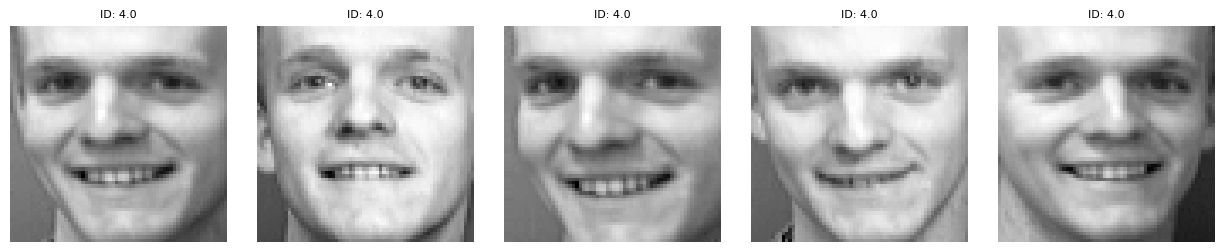

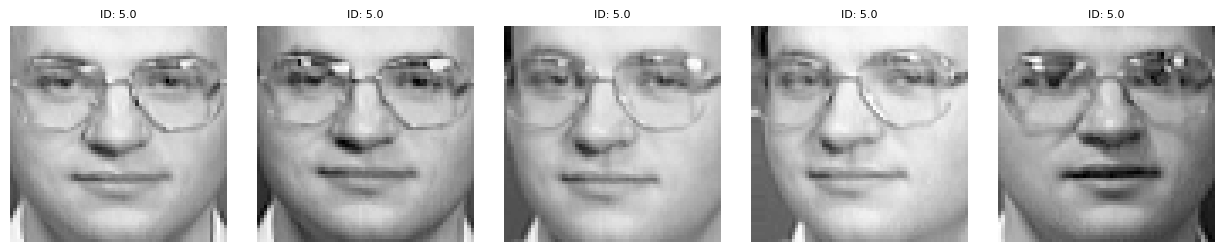

In [29]:
plot_by_class(ds, [1, 2, 3, 4, 5], 5, rand_seed=43)